## Regression Analysis on Best Model

In [1]:
"""
@author: Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from optuna_train import *
debug_mode = True  # faster experiments for debugging

import pandas as pd
print(pd.__version__)
print(pd.__path__)
assert pd.__path__[0]!='/opt/anaconda/lib/python3.8/site-packages/pandas', 'Error! You are using deprecated python packages outside your conda environment. Did you use Jupyter Lab again?' 
# this is a nefarious problem with current version of anaconda, root cause is conda version install your own local one!
# lightly more superficial root cause is that you sometimes use jupyter lab which triggers you to use the /opt/anaconda/bin path backup when it sees jupyter lab isn't in local environment which breaks everything (uses outdated pandas)

2023-02-15 20:36:51.504497: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1.5.1
['/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/pandas']


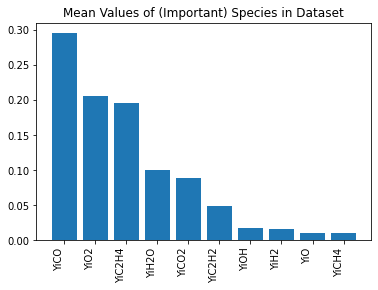

YiCO      0.295500
YiO2      0.205397
YiC2H4    0.195597
YiH2O     0.100139
YiCO2     0.088683
YiC2H2    0.048443
YiOH      0.017081
YiH2      0.016205
YiO       0.010780
YiCH4     0.009881
dtype: float64

In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer(fn='../datasets/wax_master.csv') # TODO: change me!
df = dp.getDataframe()

########################################
### Look for biggest Species Values! ###
def get_important_species(df, n=10):
    mean_vals = df.filter(like='Yi').mean()
    sort_idx = np.argsort(mean_vals)
    mean_vals = mean_vals[sort_idx][::-1][:n]
    
    # plot important species
    plt.bar(mean_vals.index, mean_vals)
    plt.title('Mean Values of (Important) Species in Dataset')
    plt.xticks(rotation=90, ha="right")
    plt.show()
    
    display(mean_vals)
    important_species = list(mean_vals.index)
    return important_species

important_species = get_important_species(df)
########################################

#df = df.sample(2)
df=pd.concat([df.iloc[:1], df.iloc[-1:]],axis=0) # select boundary conditions!
df.index=range(len(df))
dp.df = df

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)
#dm.train_portion=0.5

In [3]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2023-02-15 20:36:58.886306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 20:36:59.370472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13657 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [4]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
emb_and_regressor = bestModel = bestModel.get_layer('emb_and_regression_model')
print(experimentSettings.keys())
print(experimentSettings['dataSetMethod'])
dm.createTrainTestData(experimentSettings['dataSetMethod'], experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])

print(f'\nexperimentSettings: {str(experimentSettings)[:300]}...')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')

dict_keys(['dataSetMethod', 'ipscaler', 'opscaler', 'noOfCpv', 'ZmixPresent', 'concatenateZmix', 'kernel_constraint', 'kernel_regularizer', 'activity_regularizer', 'input_data_cols', 'data_manager', 'val_losses', 'model_R2', 'history'])
AllSpecies_randomequaltraintestsplit_AllDependants
len testing df:  1

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_AllDependants', 'ipscaler': None, 'opscaler': 'StandardScaler', 'noOfCpv': 12, 'ZmixPresent': 'Y', 'concatenateZmix': 'Y', 'kernel_constraint': 'Y', 'kernel_regularizer': 'Y', 'activity_regularizer': 'N', 'input_data_cols': ['YiCH4', 'YiH', 'Yi...

bestModel.input_shape: [(None, 53), (None, 1)]


[(None, 53), (None, 1)]
{'static_source_prediction': (None, 54), 'dynamic_source_prediction': (None, 12)}


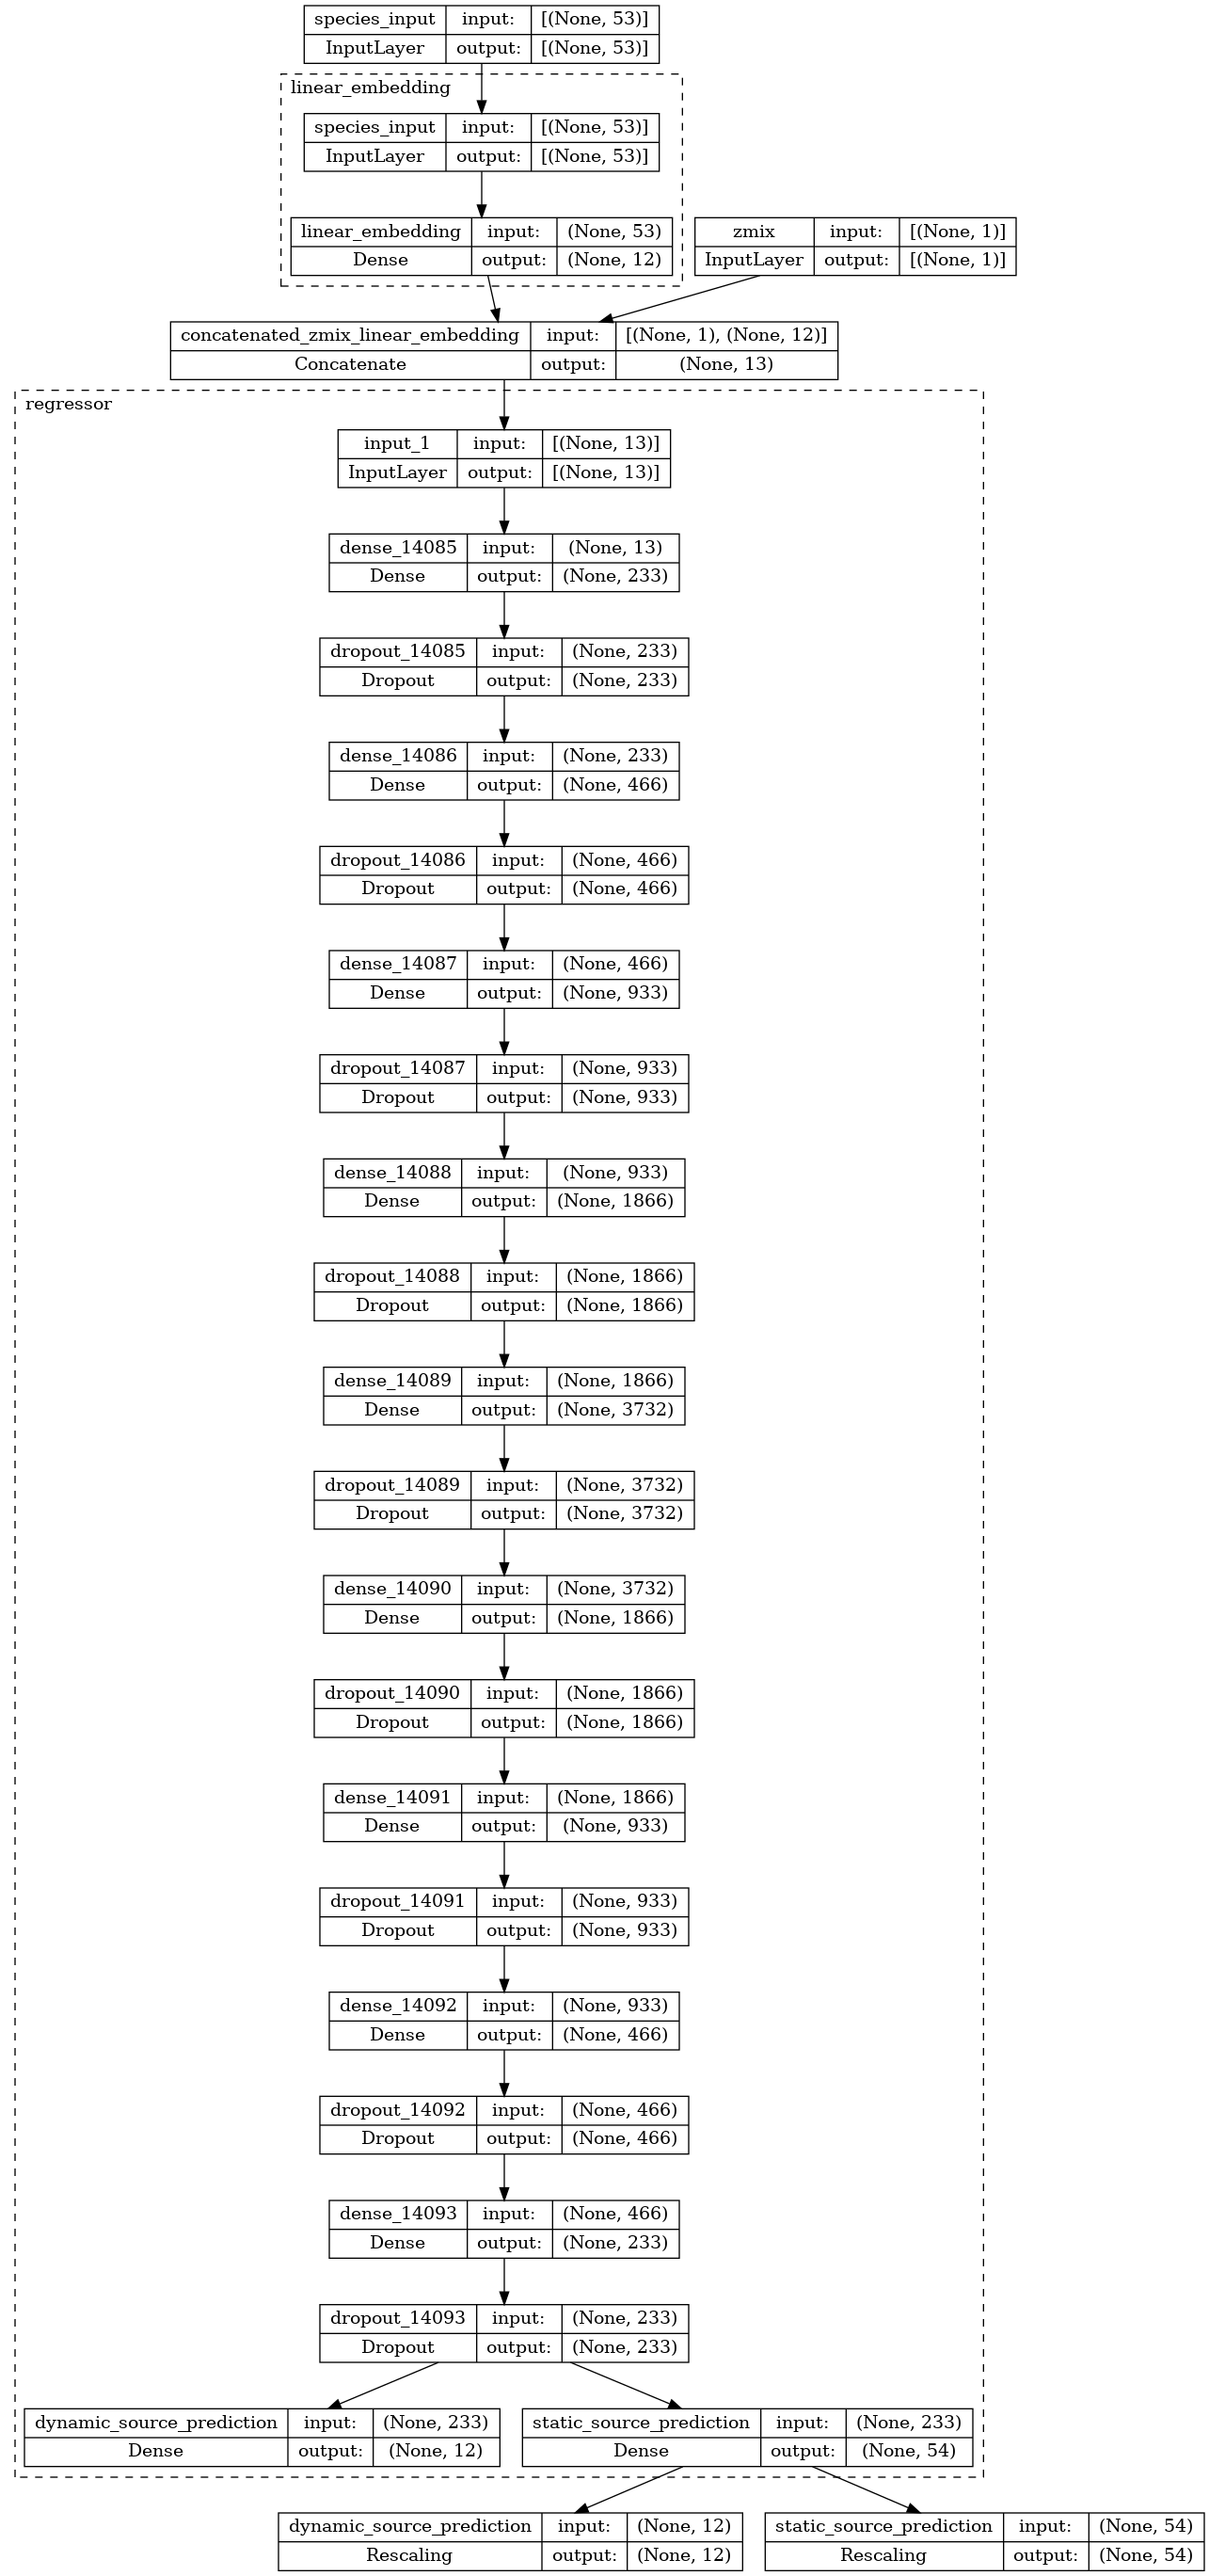

In [5]:
# simpler than reconstructing, but sanity is good...
linear_embedder = bestModel.get_layer('linear_embedding')
regressor = bestModel.get_layer('regressor')

print(bestModel.input_shape)
print(bestModel.output_shape)
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

## Alternatively load the post-processed model with enforced boundaries

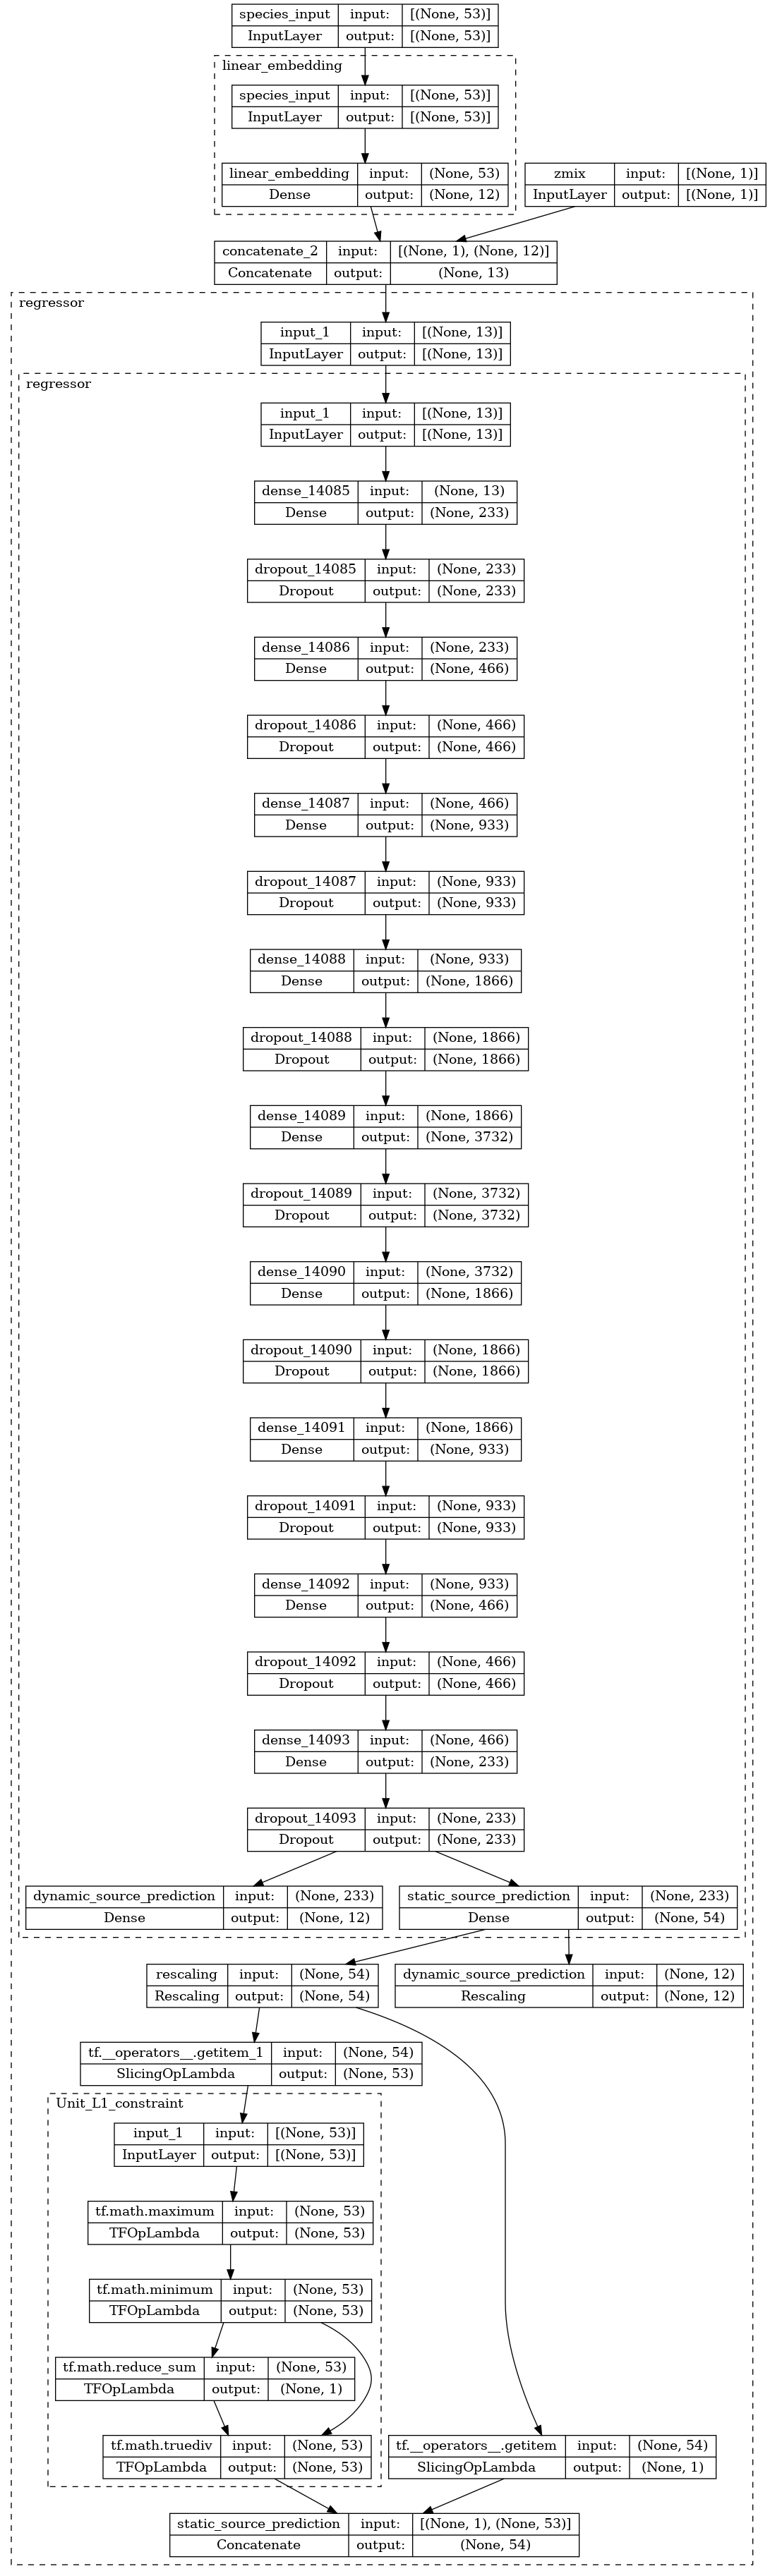

In [19]:
# TODO: find a cleaner way to include output contraints.
linear_embedder = keras.models.load_model('PCDNNV2_decomp/linear_embedding')
regressor = keras.models.load_model('PCDNNV2_decomp/regressor')

species_input = keras.layers.Input(shape=(53,), name='species_input')
zmix_input = keras.layers.Input(shape=(1,), name='zmix')

CPVs = linear_embedder(species_input)

regressor_input = keras.layers.Concatenate()([zmix_input, CPVs])
x = regressor(regressor_input)

emb_regressor = keras.models.Model(inputs={'zmix': zmix_input, 'species_input': species_input}, outputs=x)
tf.keras.utils.plot_model(emb_regressor, expand_nested=True, show_shapes=True)

## Manually Construct Data & Prepare Model:

In [20]:
X_train, X_test, Y_train, Y_test, zmix_train, zmix_test = dm.getTrainTestData()
source_train, source_test = dm.getSourceTrainTestData()

In [21]:
# This is a hack to plot regression analysis for just the boundary cases
X_test, Y_test, zmix_test, source_test = dm.getAllData()

In [22]:
CPV_train = linear_embedder({"species_input": np.asarray(X_train)})
true_dyn_train = linear_embedder({"species_input": np.asarray(source_train)})
true_dyn_test = linear_embedder({"species_input": np.asarray(source_test)})

In [23]:
input_dict_train = {"species_input": X_train, 'zmix': zmix_train}
input_dict_test = {"species_input": X_test, 'zmix': zmix_test}
output_dict_train = {'static_source_prediction': Y_train, 'dynamic_source_prediction': true_dyn_train}
output_dict_test = {'static_source_prediction': Y_test, 'dynamic_source_prediction': true_dyn_test}

In [24]:
from models import pcdnnv2_model_factory

@tf.function
def R2(yt,yp): return tf.reduce_mean(1-tf.reduce_mean((yp-yt)**2, axis=0)/tf.math.reduce_variance(yt,axis=0))

# for metric definitions see get_metric_dict()
metrics={'static_source_prediction': R2, 'dynamic_source_prediction': R2}
emb_and_regressor.compile(loss=None, optimizer='adam', metrics=metrics)

# Best Model Evaluation:
## R^2 Eval -- 
(**NOTE: requires max batch size or you get erroneous results!**)

In [25]:
# Verified to make "raw evaluation" (7/27/22) (as long as batch size is entire dataset!)
eval_ = emb_and_regressor.evaluate(input_dict_train, output_dict_train, batch_size=X_train.shape[0], return_dict=True, verbose=False)

# legacy compatibility
if 'regressor_R2' in eval_ or 'regressor_1_R2' in eval_:
    eval_['static_source_prediction_R2'] = eval_['regressor_R2']
    eval_['dynamic_source_prediction_R2'] = eval_['regressor_1_R2']
print(eval_)

print(f'Total loss: {eval_["loss"]}')
print(f'CPV_source_prediction R^2: {eval_["dynamic_source_prediction_R2"]}')
print(f'Static_deps_prediction R^2: {eval_["static_source_prediction_R2"]}')
print(f'Average R^2: {(eval_["dynamic_source_prediction_R2"]+eval_["static_source_prediction_R2"])/2}')

{'loss': 0.0038341416511684656, 'dynamic_source_prediction_R2': -inf, 'static_source_prediction_R2': -inf}
Total loss: 0.0038341416511684656
CPV_source_prediction R^2: -inf
Static_deps_prediction R^2: -inf
Average R^2: -inf


## QQ regression plots:

['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR']
1/1 [==============================] - 0s 133ms/step
mae 0.40713471012121


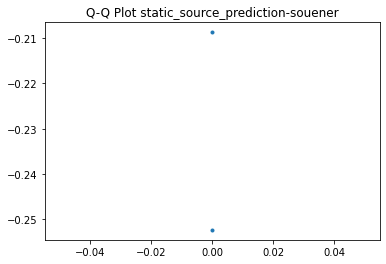

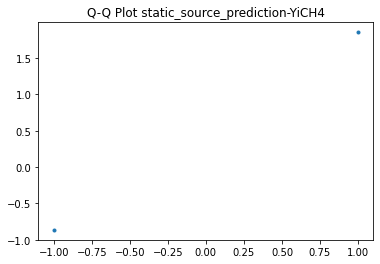

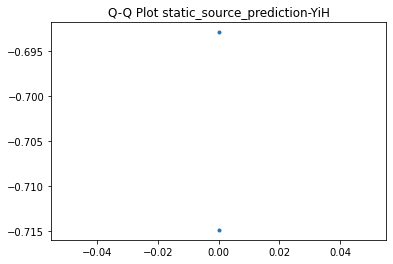

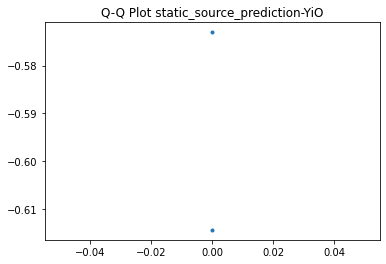

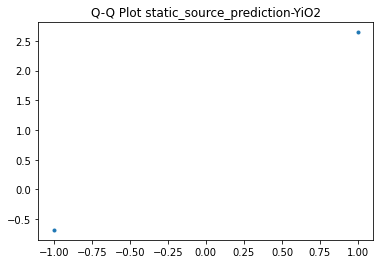

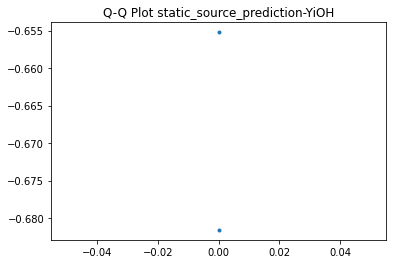

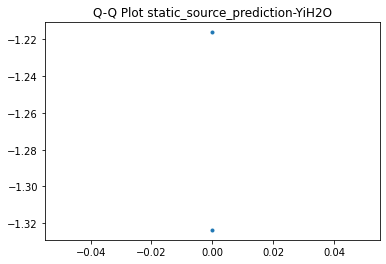

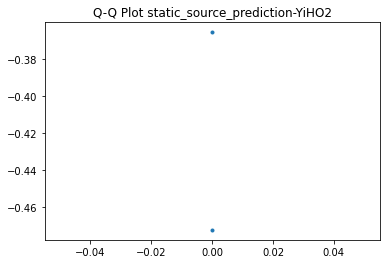

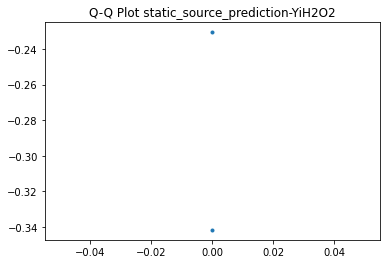

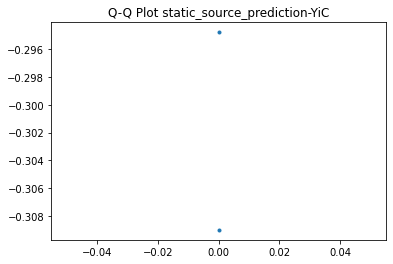

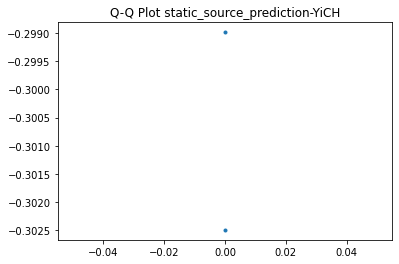

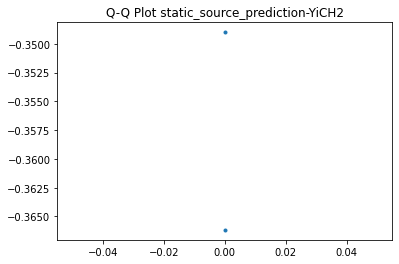

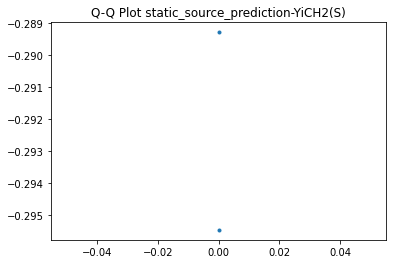

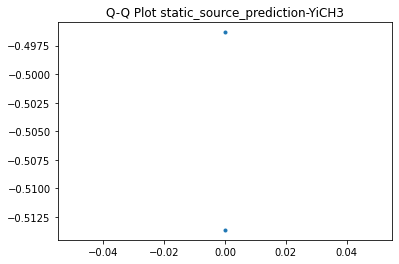

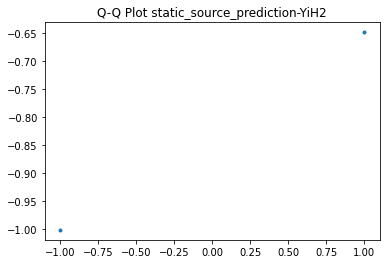

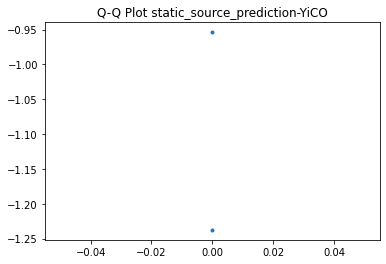

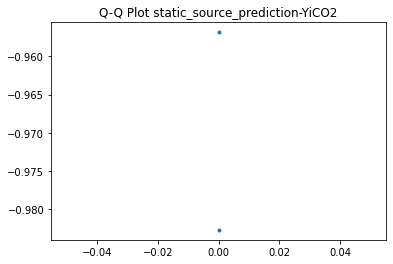

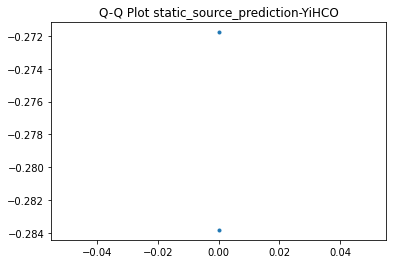

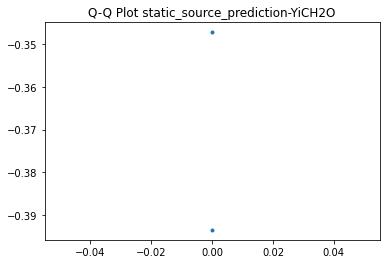

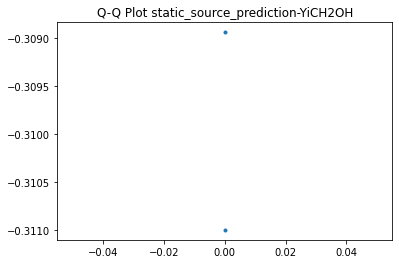

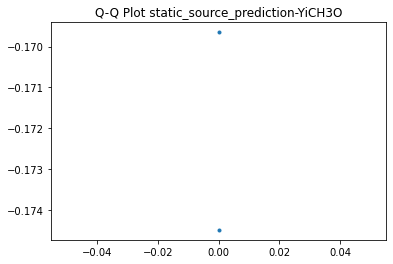

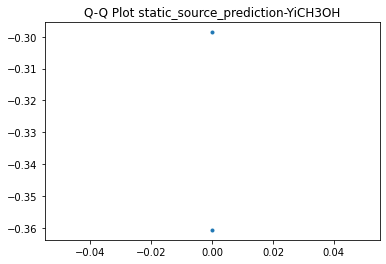

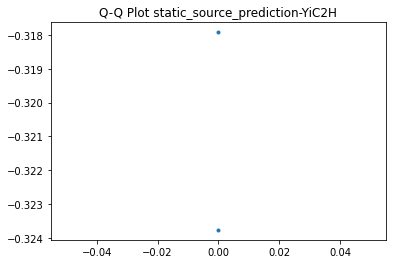

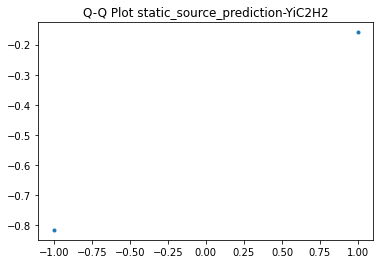

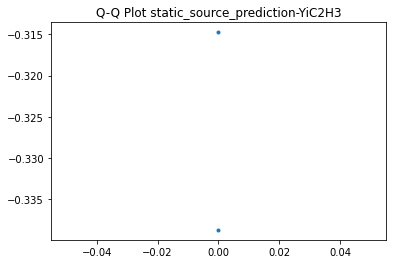

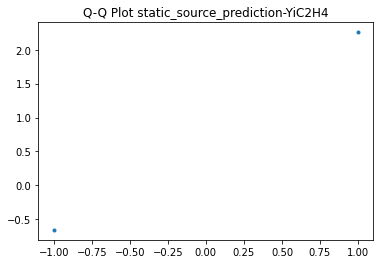

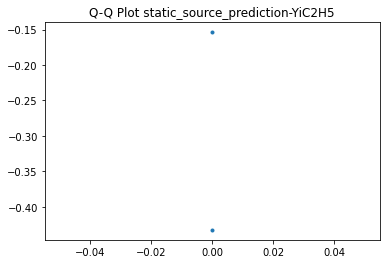

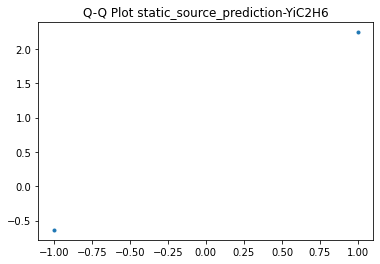

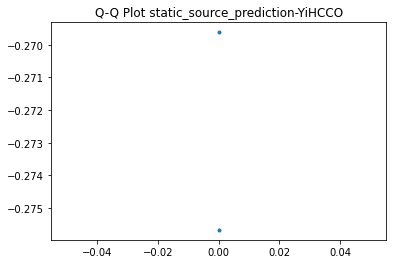

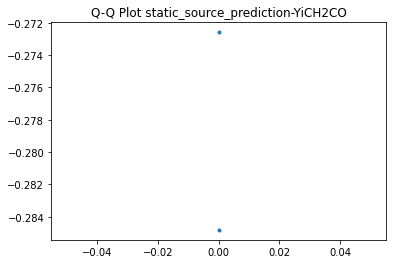

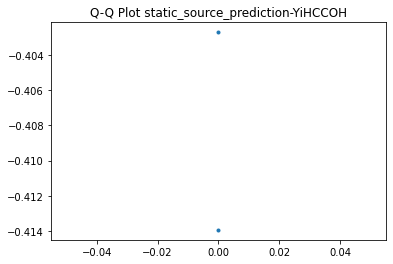

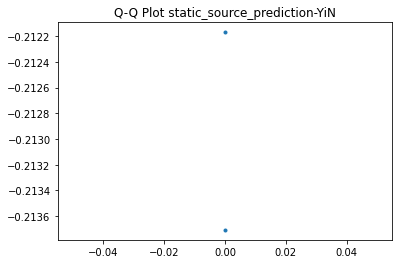

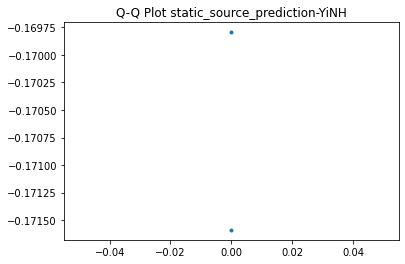

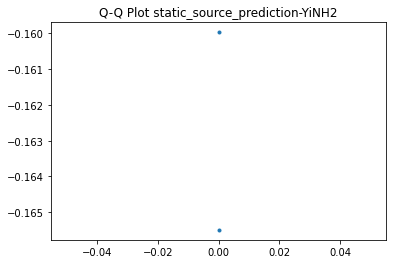

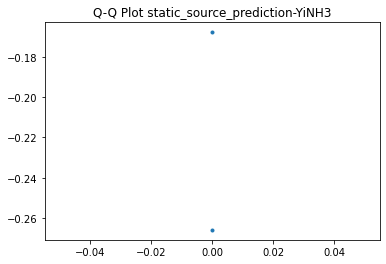

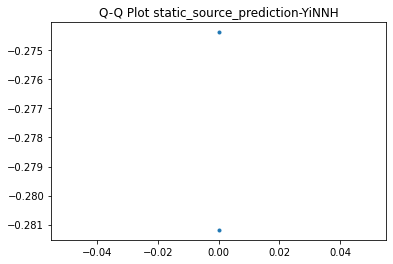

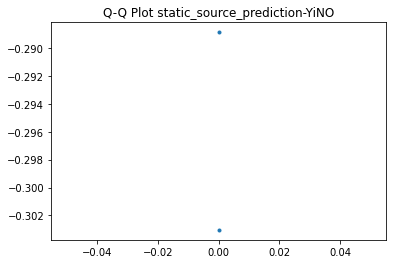

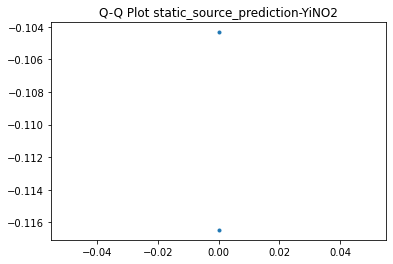

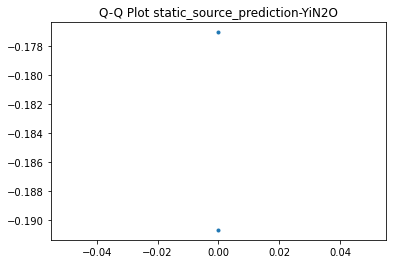

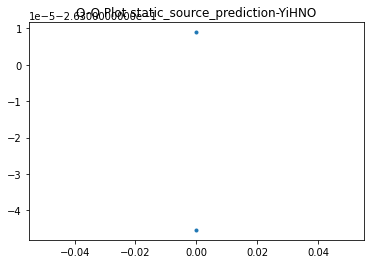

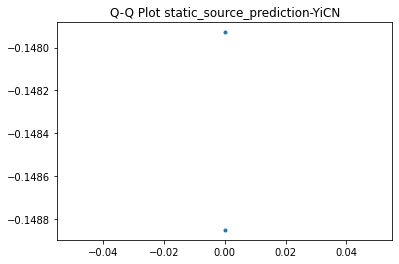

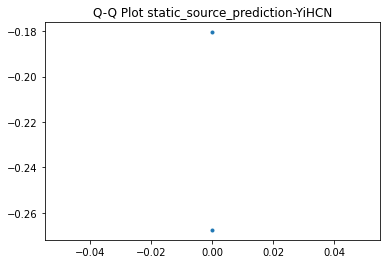

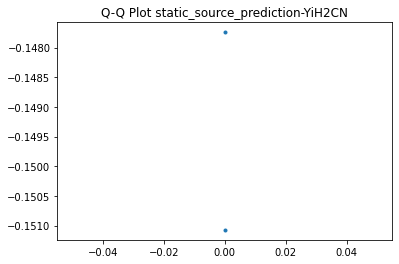

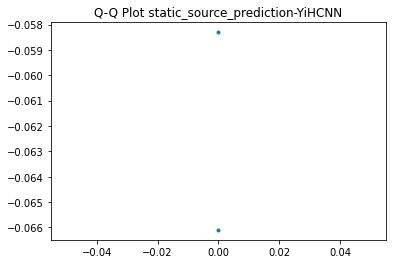

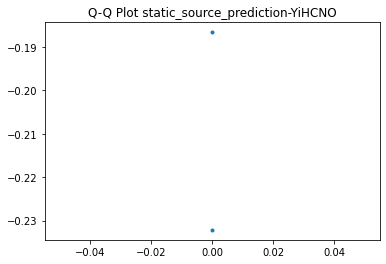

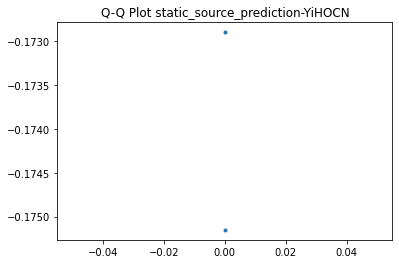

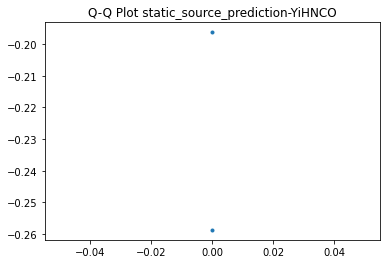

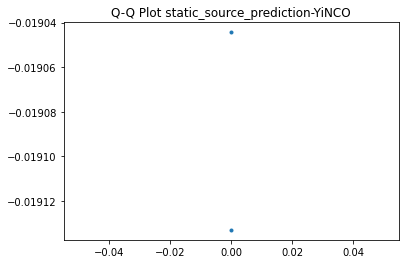

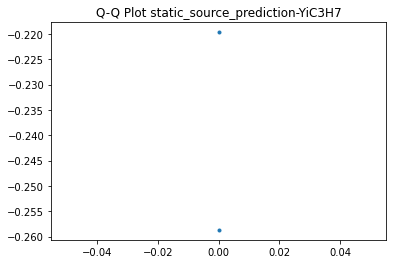

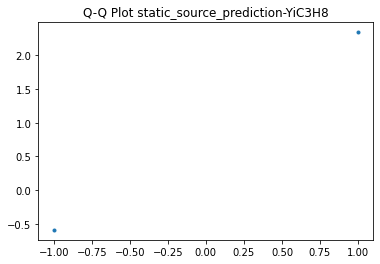

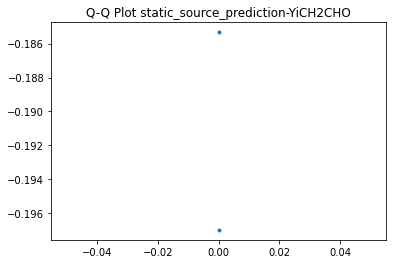

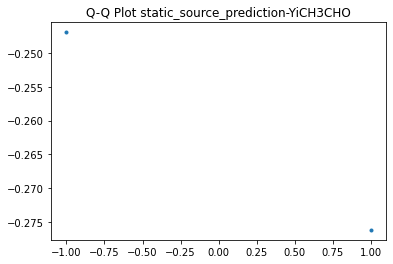

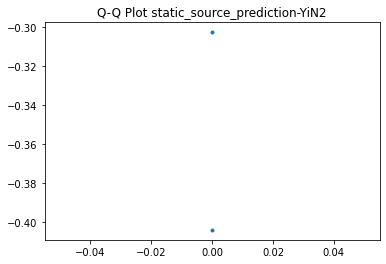

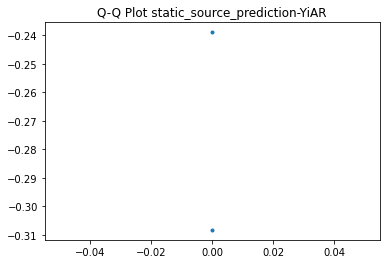

1/1 [==============================] - 0s 17ms/step
mae 0.30081794


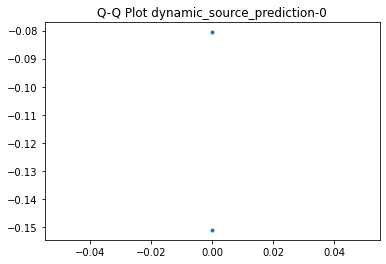

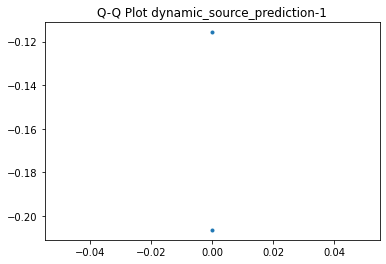

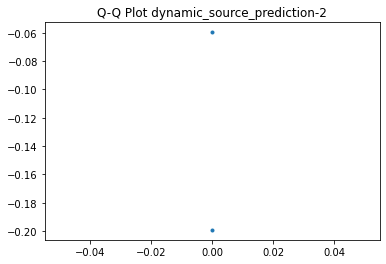

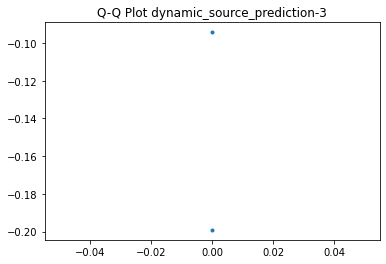

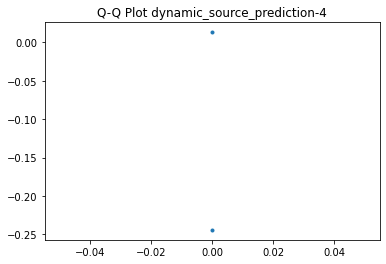

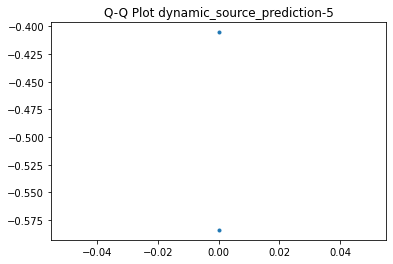

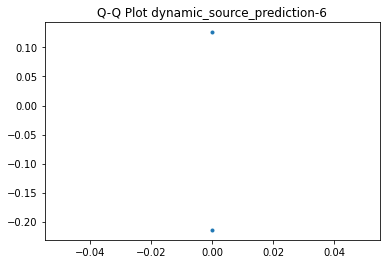

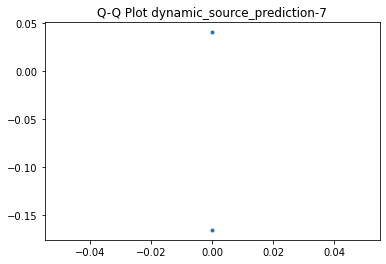

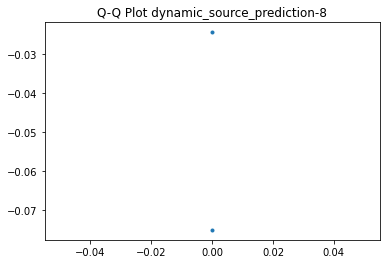

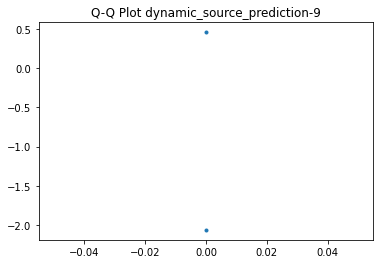

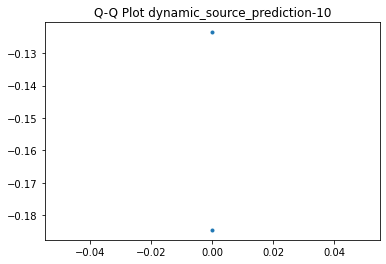

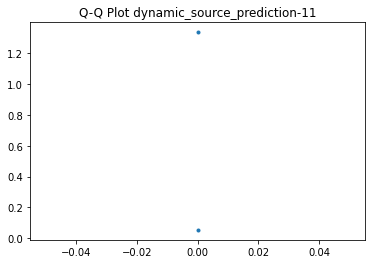

<tf.Tensor: shape=(2, 12), dtype=float32, numpy=
array([[ 0.15091014,  0.11573339,  0.19913507,  0.19911176,  0.24438483,
         0.58381116,  0.2144266 ,  0.16527337,  0.07512444,  2.0628889 ,
         0.1844545 , -0.05420947],
       [ 0.08060992,  0.20645237,  0.05958462,  0.09429765, -0.01335302,
         0.40529084, -0.12625471, -0.04076886,  0.02431983, -0.46028608,
         0.12359947, -1.3353498 ]], dtype=float32)>

In [12]:
import matplotlib.pyplot as plt

# QQ plots are good!!
#all_dependants = ["souener", "souspecO2", "souspecCO", "souspecCO2", "souspecH2O", "souspecOH", "souspecH2", "souspecCH4"]
all_dependants = ["souener"] + dm.input_data_cols
print(dm.input_data_cols)
def make_Error_plots(input_dict, output_dict, name, plot_residuals=False, names=None):
    preds = emb_and_regressor.predict(input_dict)
    if names is None: names = list(range(preds[name].shape[1]))
    
    residuals = output_dict[name]-preds[name]
    print('mae', np.mean(np.abs(residuals)))
    Y_vals = residuals if plot_residuals else preds[name]
    plt_name = 'Residual' if plot_residuals else 'Q-Q'
    
    for i in range(preds[name].shape[1]):
        plt.figure(i)
        plt.plot(output_dict[name][:, i], Y_vals[:,i], '.')
        plt.title(f'{plt_name} Plot {name}-{names[i]}')
        plt.show()
    return residuals
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=False)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=False)

## Compare Boundary Conditions Predictions to Real Values

In [140]:
# TODO: find out why predictions are crazy

#important_species = ["souspecO2", "souspecCO", "souspecCO2", "souspecH2O", "souspecOH", "souspecH2", "souspecCH4"]
#important_species = [x.replace('souspec', 'Yi') for x in important_species]

#df.filter(like='Yi').mean()

1/1 [==============================] - 0s 44ms/step
targets: 


,YiCO,YiO2,YiC2H4,YiH2O,YiCO2,YiC2H2,YiOH,YiH2,YiO,YiCH4
0,0.0,1.0,0.00000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000
1,0.0,0.0,0.90856,0.0,0.0,0.019041,0.0,2.660525e-08,0.0,0.031301


preds: 


,YiCO,YiO2,YiC2H4,YiH2O,YiCO2,YiC2H2,YiOH,YiH2,YiO,YiCH4
0,0.001038,0.963676,0.022793,0.004847,0.004693,0.000000,0.000098,0.000000,0.000940,0.000789
1,0.068544,0.013261,0.788977,0.012526,0.006845,0.039009,0.000755,0.005543,0.000219,0.029410


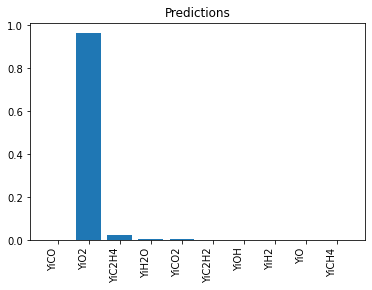

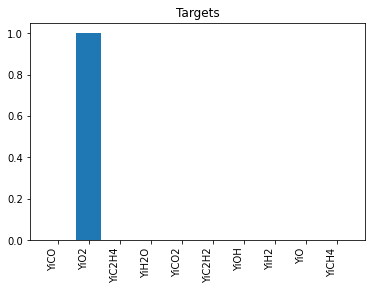

1/1 [==============================] - 0s 22ms/step
targets: 


,YiCO,YiO2,YiC2H4,YiH2O,YiCO2,YiC2H2,YiOH,YiH2,YiO,YiCH4
0,0.0,1.0,0.00000,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.000000
1,0.0,0.0,0.90856,0.0,0.0,0.019041,0.0,2.660525e-08,0.0,0.031301


preds: 


,YiCO,YiO2,YiC2H4,YiH2O,YiCO2,YiC2H2,YiOH,YiH2,YiO,YiCH4
0,0.001038,0.963676,0.022793,0.004847,0.004693,0.000000,0.000098,0.000000,0.000940,0.000789
1,0.068544,0.013261,0.788977,0.012526,0.006845,0.039009,0.000755,0.005543,0.000219,0.029410


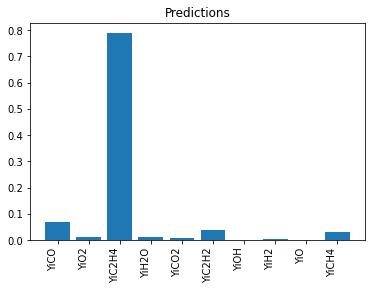

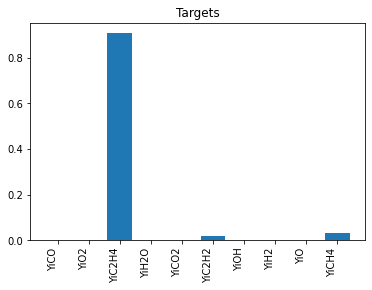

In [30]:

# TODO: consider merging these 2 functions & creating just 1 flag?
def preds_and_targets_emb_regressor(input_dict_test, output_dict_test):
    preds = emb_and_regressor.predict(input_dict_test)
    preds = pd.DataFrame(dm.outputScaler.inverse_transform(preds['static_source_prediction'])[:,1:], columns=dm.input_data_cols)
    targets = pd.DataFrame(dm.outputScaler.inverse_transform(output_dict_test['static_source_prediction'])[:,1:], columns=dm.input_data_cols)
    return preds, targets

def preds_and_targets_post_constraints(input_dict_test, output_dict_test):
    preds = emb_regressor.predict(input_dict_test)
    preds = pd.DataFrame(preds['static_source_prediction'][:,1:], columns=dm.input_data_cols)
    targets = pd.DataFrame(dm.outputScaler.inverse_transform(output_dict_test['static_source_prediction'])[:,1:], columns=dm.input_data_cols)
    return preds, targets

def plot_inv_comparison(row_id = 0, get_preds_and_targets=preds_and_targets_emb_regressor):
    preds, targets = get_preds_and_targets(input_dict_test, output_dict_test)
    preds = preds[important_species]
    targets = targets[important_species]
    
    print('targets: ')
    display(targets)
    print('preds: ')
    display(preds)

    plt.bar(preds.columns, preds.iloc[row_id])
    plt.xticks(rotation=90, ha="right")
    plt.title('Predictions')
    plt.show()

    plt.bar(preds.columns, targets.iloc[row_id])
    plt.xticks(rotation=90, ha="right")
    plt.title('Targets')
    plt.show()
#plot_inv_comparison(0)
#plot_inv_comparison(1)

plot_inv_comparison(0, get_preds_and_targets=preds_and_targets_post_constraints)
plot_inv_comparison(1, get_preds_and_targets=preds_and_targets_post_constraints)

## Residual Regression Plots:

1/1 [==============================] - 0s 13ms/step
mae 0.80865637316472


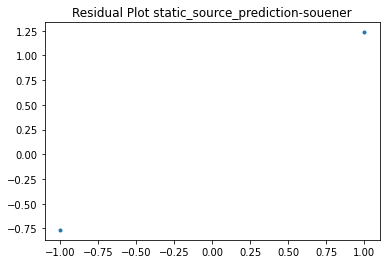

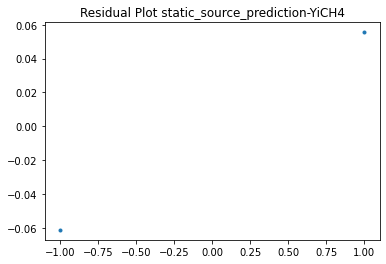

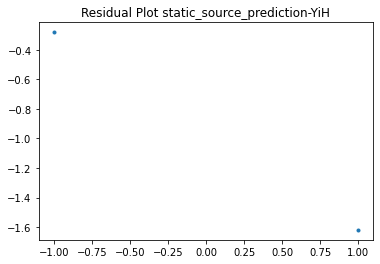

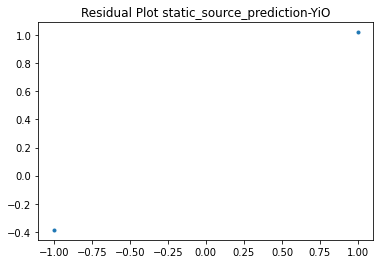

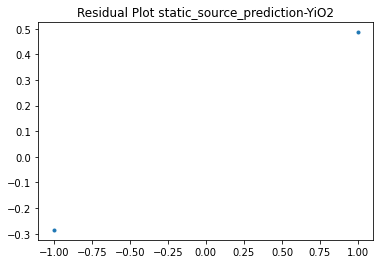

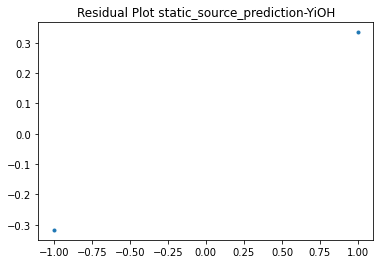

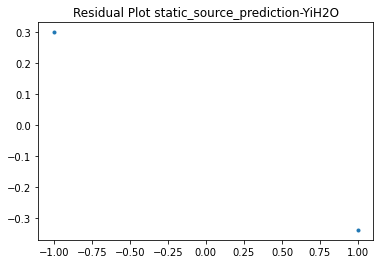

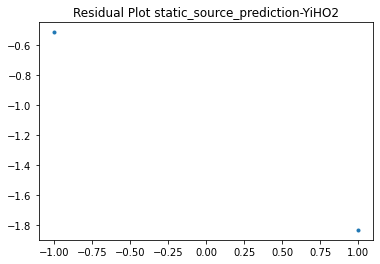

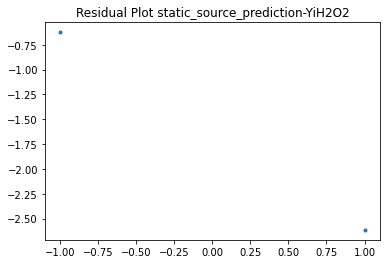

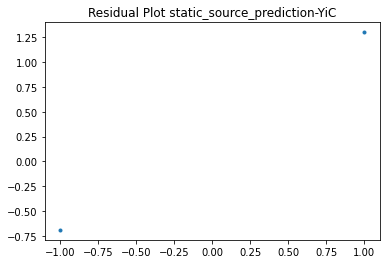

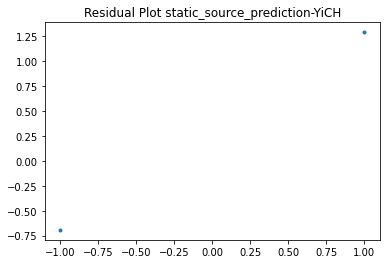

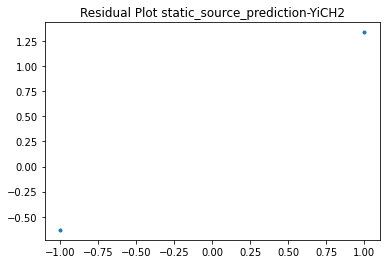

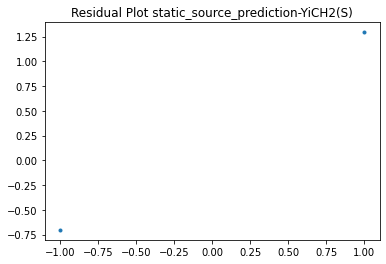

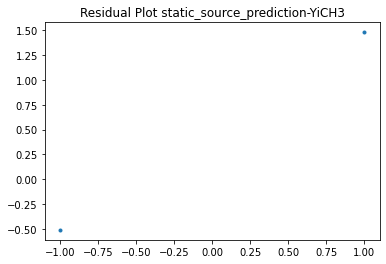

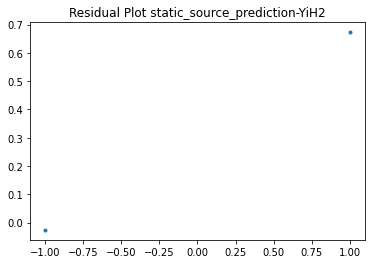

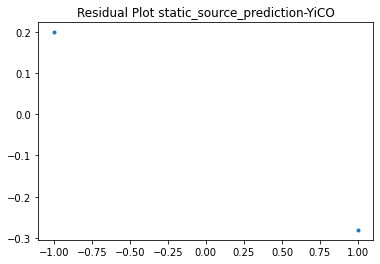

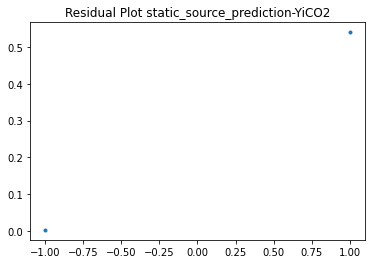

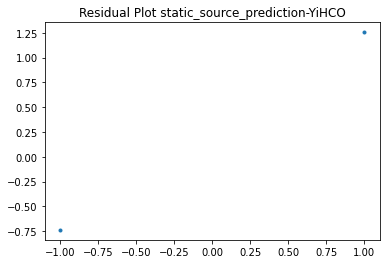

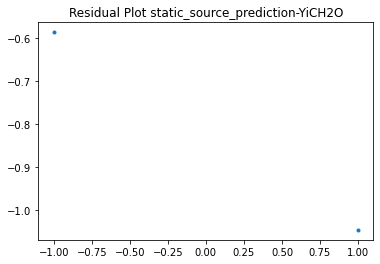

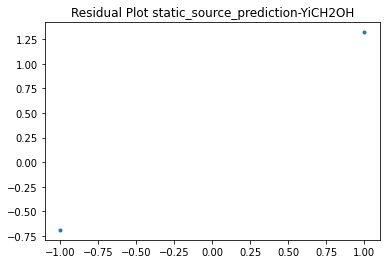

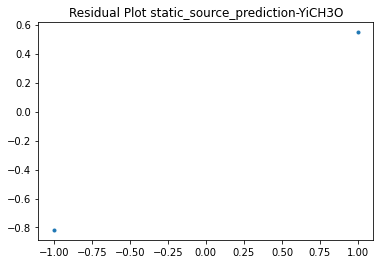

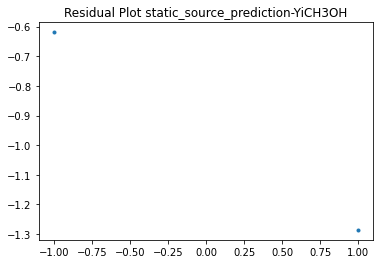

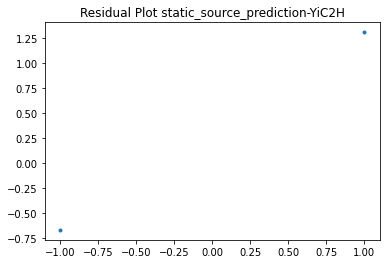

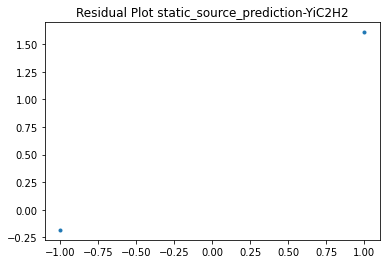

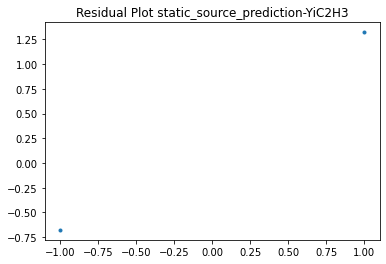

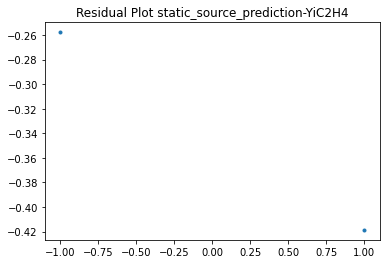

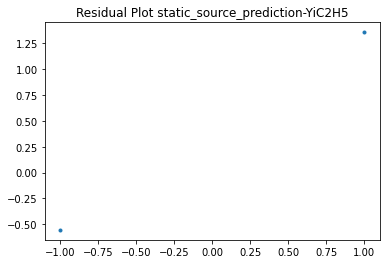

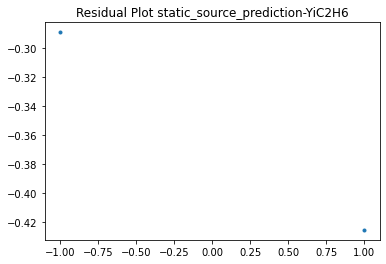

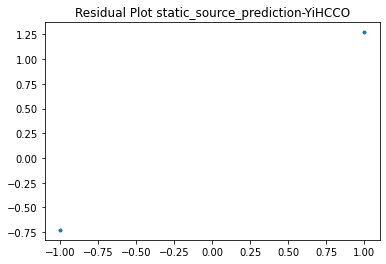

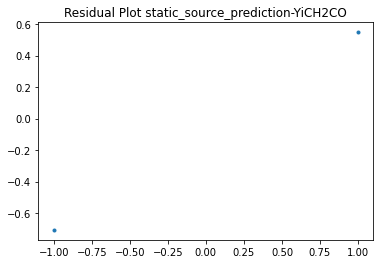

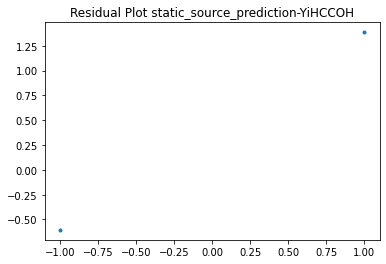

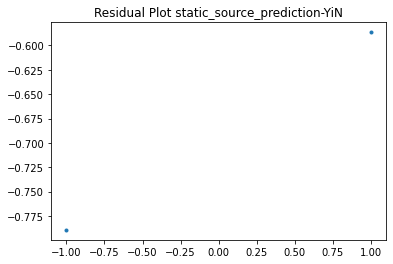

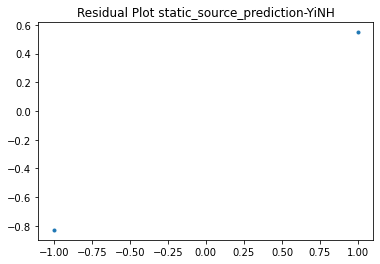

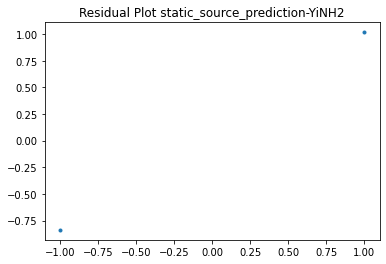

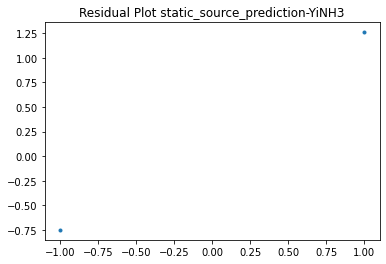

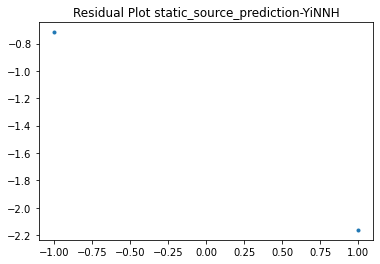

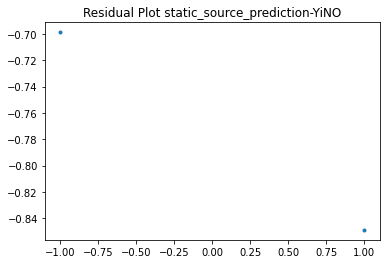

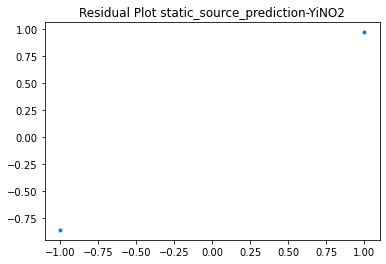

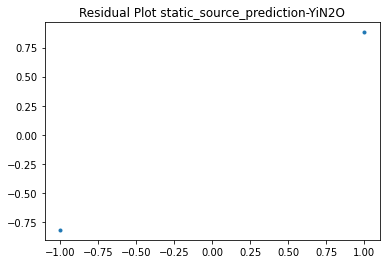

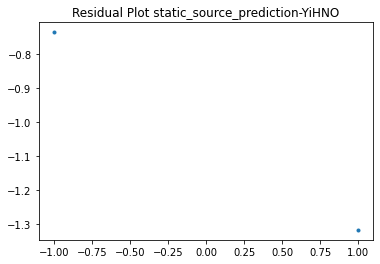

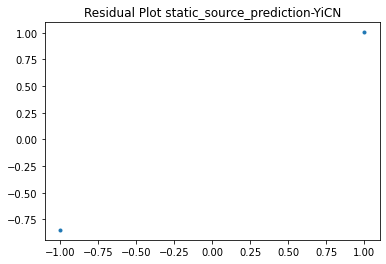

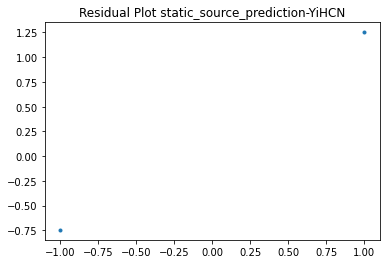

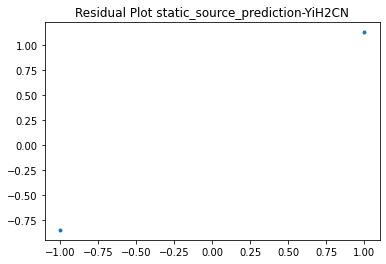

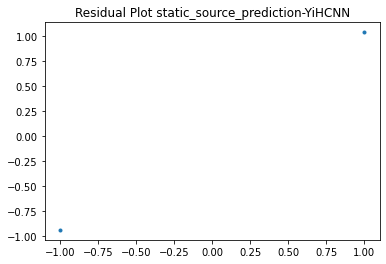

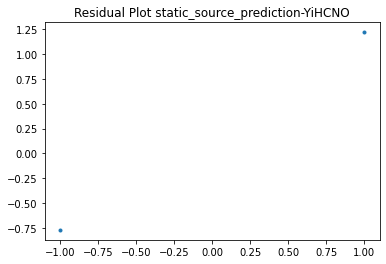

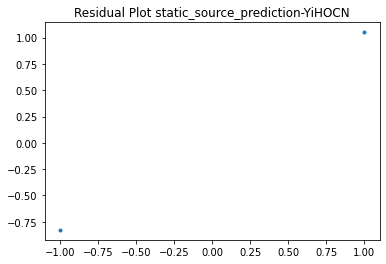

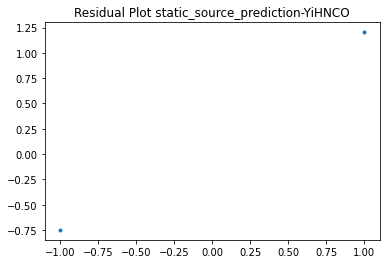

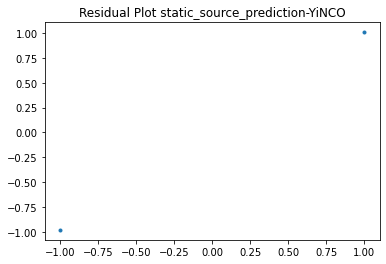

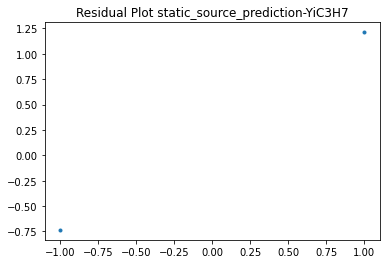

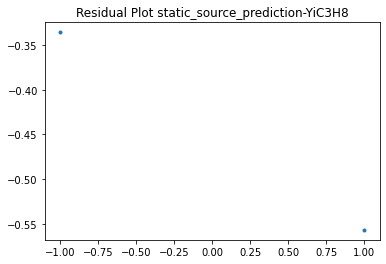

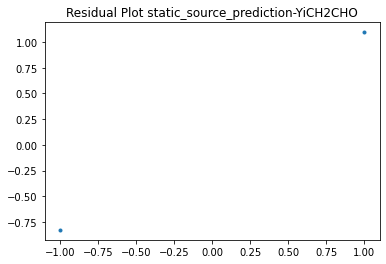

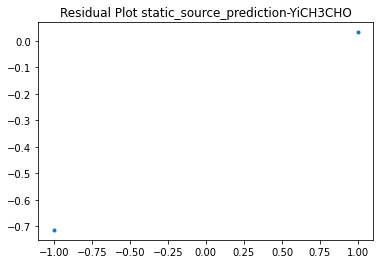

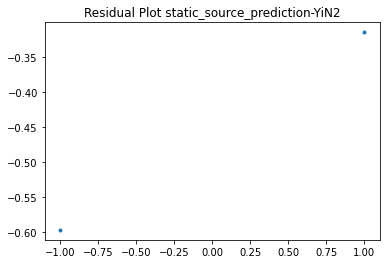

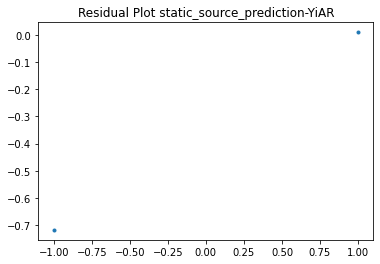

1/1 [==============================] - 0s 14ms/step
mae 0.47020426


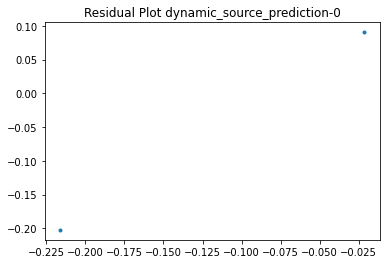

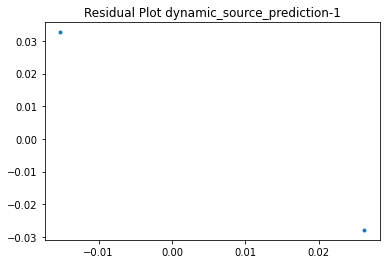

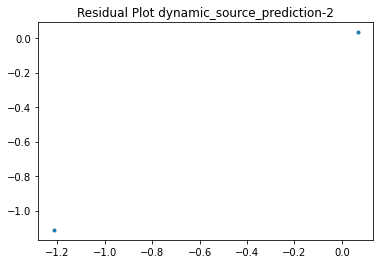

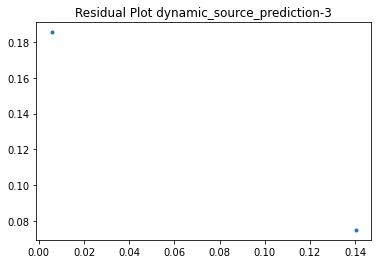

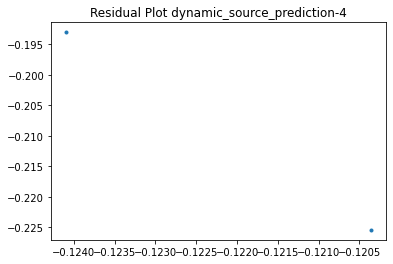

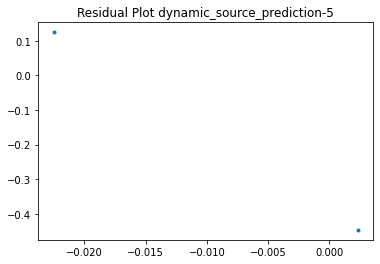

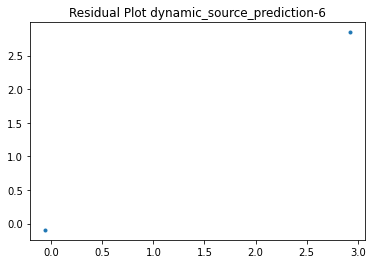

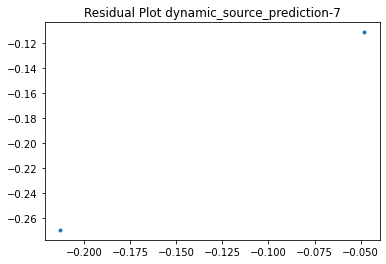

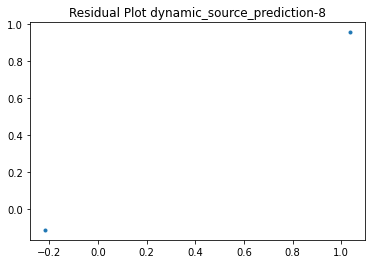

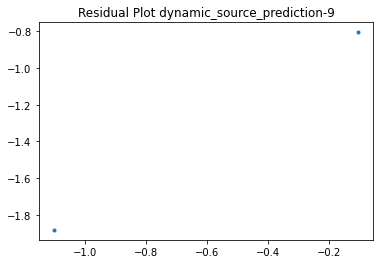

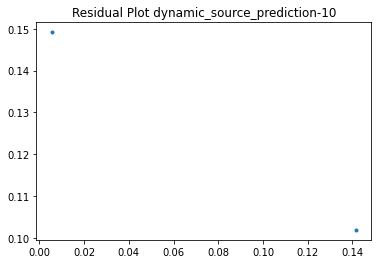

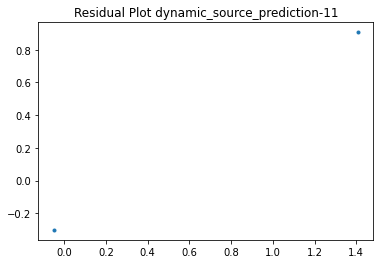

<tf.Tensor: shape=(2, 12), dtype=float32, numpy=
array([[-0.20225567, -0.02786412,  0.03423414,  0.07499386, -0.19303632,
        -0.44658718, -0.09425519, -0.11125132,  0.9564941 , -1.8811519 ,
         0.10188706, -0.30112976],
       [ 0.09037752,  0.03264319, -1.1119528 ,  0.18546556, -0.22543639,
         0.12508295,  2.8465636 , -0.26944053, -0.11170805, -0.80550706,
         0.14916377,  0.90642   ]], dtype=float32)>

In [142]:
make_Error_plots(input_dict_test, output_dict_test, 'static_source_prediction', names=all_dependants, plot_residuals=True)
make_Error_plots(input_dict_test, output_dict_test, 'dynamic_source_prediction', plot_residuals=True)

### CPV Distribution Plots (its Weird!):

TypeError: len() of unsized object

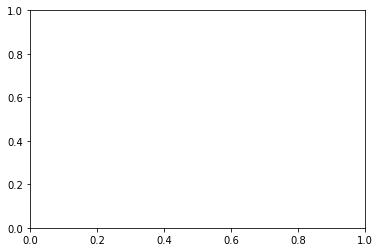

In [143]:
for i in range(CPV_train.shape[1]):
    plt.figure(i)
    plt.hist(CPV_train[:,i].numpy().squeeze())
    plt.title(f'CPV-{i} hist')
    plt.show()

In [ ]:
# Sanity check on names!
def sanity_check_names(): # function to prevent namespace pollution
    input_dict_train, input_dict_test, output_dict_train, output_dict_test = exprExec.prepare_model_data_dicts(dm=dm)
    X_train_cols = dm.df_testing[dm.input_data_cols].columns
    source_train_cols = source_train.columns

    # check that order of source-terms matches order of species
    assert all(np.array([col[2:] for col in X_train_cols]) == np.array([col[7:] for col in source_train_cols]))
sanity_check_names()